<a href="https://colab.research.google.com/github/OleksiiLatypov/Practical_Deep_Learning_with_PyTorch/blob/main/week3/template_yolo_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# You Only Look Once Algorithm (YOLO)

Welcome! In this lab, you will have an opportunity to implement some parts of the YOLO algorithm. In the ResNet18 lab, we learned how to use a pre-trained model for image classification. Now, we will learn how to classify multiple objects into n classes and find a bounding box around each object. In short, we will implement an image detection algorithm. Let's get started!

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- How to make predictions with YOLOv3 algorithm
    - How to preprocess an image
    - How to filter boxes by their confidence
    - How to use Non-maximum Suppression (NMS)
    - How to visualize the results

# 0 - Download data

In [1]:
!pip install wget
import wget
wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/3_conv_nn/yolo_inference/template.zip')
!unzip -q template.zip

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=9369f476f4fe1fd9149ae699ce514e6691b5e4628192250f26ef90251aa62ebf
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# 1 - Import packages

In addition to our regular packages, we will use [Pillow](https://pillow.readthedocs.io/en/stable/) — a common imaging library for Python.

In [2]:
# local imports
from models import Darknet

# packages
import random
import numpy as np
from PIL import Image

import torch
from torchvision import transforms

import matplotlib.patches as patches
import matplotlib.pyplot as plt

%matplotlib inline

## Configs

In [3]:
# VALIDATION_FIELD[cls] Config
class Config:
    # path
    config_path = 'config/yolov3.cfg'
    weights_path = 'yolov3.weights'
    classes_path = 'config/coco.names'
    image_path = 'zoo.png'

    # model
    img_size = 416
    conf_thresh = 0.2
    nms_thresh = 0.4
    seed = 21
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
random.seed(Config.seed)
np.random.seed(Config.seed)
torch.manual_seed(Config.seed);

## Load pretrained model for inference

In this lab we used a pretrained model from [cfotache](https://github.com/cfotache/pytorch_objectdetecttrack.git) implemetation of YOLO_v3 algorithm.

In [5]:
with open(Config.classes_path, "r") as fp:
    class_labels = fp.read().split("\n")[:-1]

In [6]:
# Load model and weights
model = Darknet(Config.config_path, img_size=Config.img_size)
model.load_weights(Config.weights_path)
model.to(Config.device)
model.eval();

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# 2 - Theory behind YOLO_v3

## Underlying model
The model that we just imported is a core of the YOLO algorithm. The key property of this model is that it's **fully convolutional** (doesn't use linear layers), meaning that it can operate with images of any size. The **stride** (reduction factor) of this neural network is 32, meaning that the input image of the shape `[1, 3, 416, 416]` will be transformed to the size of `[1, num_features, 13, 13]`, where $1$ is the batch size, and `num_features` is an output number of channels. We can also interpret the output of a **fully convolutional** network as if it makes a prediction for each 13x13 section of the original image.

An updated version of the YOLO algorithm, `YOLO_v3`, makes predictions across three different scales. So, instead of just sending an image through an entire neural network of a stride 32, `YOLO_v3` has two additional output heads in different parts of the architecture that reduce the image by a factor of 16 and 8, respectively. To sum up, if we have an input image of shape `[1, 3, 416, 416]`, the raw output will be three tensors of shapes `[1, num_features, 13, 13]`, `[1, num_features, 26, 26]`, and `[1, num_features, 52, 52]`. **Note** that each output has the same `num_features`, which is achieved by using 1x1 convolutions to give the output a fixed number of dimensions.

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/yolo_3_scales.png">

## How to interpret `num_features`?

So, how do we know what's happening in each section of our image? In the simplest case, for each section, YOLO will output an **85** dimensional vector that would define our box. By our configuration, first **4** values will represent absolute x and y coordinates of a center, width, and height that we will label $b_x$, $b_y$, $b_w$, and $b_h$ respectively. **5**th value will represent a probability of having a center of **ANY** object in the box, $p_c$, and the remaining values will be probabilities of each individual class $p_i$ (where $i\in[1, n_{classes}])$ that we are trying to detect. Since the **COCO** dataset has 80 classes, there will be 80 values for class probabilities. This leaves us with an **85** dimensional vector that describes one box prediction. In reality, however, there might be more than one object in each section of an image. So, instead, YOLO_v3 predicts three boxes for each section of an image, resulting in $3 * 85 = 255$ dimensional vector for each section.  

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/box_vector.png">

**Note that in YOLO only the cell containing the center of the object is responsible for prediction.** So, if the center of the object is located in the section, that section should have $p_c\approx1$. While, the nearby sections should predict $p_c\approx0$, meaning that the object center was not detected, even if the object itself spans across several boxes. But which of the three boxes should detect our object? To answer this question, we need to understand the concept of **anchor** boxes.

## Anchors

Imagine you are building a dataset of target labels for some images. If you have two people $A$ and $B$ in a single section of the image, how do you form a target label for your prediction using your three boxes? If you put $A$ into the first box, $B$ into the second, and no-object into the third, that will be very different from putting $B$ into the first box, no-object into the second, $A$ into the third. The reason for that is that boxes are **NOT order invariant,** meaning that the order in which you place your predictions into three target boxes matters for a Neural Network. So, how do you come up with a system to order the objects in the boxes?

YOLO developers came up with a solution - **anchor boxes**. Anchor box is simply two predefined numbers $(w, h)$ that represent the width and height of a box used for comparison. In config, we define three anchor boxes for each scale of the output image.

| Scale | Anchors                        |
|-------|--------------------------------|
| 13x13 | (10,13), (16,30), (33,23)      |
| 26x26 | (30,61), (62,45), (59,119)     |
| 52x52 | (116,90), (156,198), (373,326) |

Then, to determine what object goes where, we simply compare the actual height and width of the object to the height and width of the anchor. If, for example, our object has dimensions $(12, 12)$, we will place it into the first box because anchor $(10, 13)$ is the closest to our prediction. More concretely, we will compute **Intersection Over Union(IoU)** between our object and three anchor boxes to decide which of the three boxes to use for our object.

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/anchors.png">

This setting for target labels will force our model to predict three boxes of different parameters. For example, in a $13x13$ resolution, first box (corresponds to the $(10,13)$ anchor) will predict roughly square objects, second box (anchor $(16, 30)$) — tall objects, and the last box ($(33, 23)$ anchor) — wide objects.

## Restrictions on the output vector

Remember that all these settings are made so far on our **target labels**. The model itself doesn't know what we are trying to learn, so it will simply output **real-valued** vector. Therefore, we need to set some restrictions on the output vector.

Let's denote target box-vector using $[b_x, b_y, b_w, b_h, p_c, p_1, p_2, \dots , p_{80}]$, where:
* $b_x\in(0, 416)$ - absolute $x$ coordinate of the image center measured from top-left corner
* $b_y\in(0, 416)$ - absolute $y$ coordinate of the image center measured from top-left corner
* $b_w\in(0, 416)$ - width of the object (assuming an object is fully present on the image)
* $b_h\in(0, 416)$ - height of the object
* $p_c\in(0, 1)  $ - probability of detecting an object
* $p_i\in(0, 1)  $ - probability of the i-th class on the image

**Restrictions:**
* we want all of our predicted values to be in appropriate ranges
* $b_x$ and $b_y$ must be inside of a given box
* $b_w$ and $b_h$ must be as close as possible to a given anchor box $(A_w, A_h)$.

The output vector from Neural Network is $[t_x, t_y, t_h, t_w, t_c, t_1, t_2, \dots , t_{80}]$, where $t_{j}\in(-\infty, \infty)$. With this huge range, the task of learning our target labels becomes incredibly difficult for neural network. To resolve this problem, we define the following postprocessing steps for the output vector:


$$b_x = \sigma(t_x) + c_x \tag{1}$$
$$b_y = \sigma(t_y) + c_y \tag{2}$$<br>
$$b_w = p_w\cdot e^{t_w} \tag{3}$$
$$b_h = p_h\cdot e^{t_h} \tag{4} $$<br>
$$p_c = \sigma(t_c) \tag{5}$$
$$p_i = \sigma(t_i) \tag{6}$$

where $c_x$ and $c_y$ are the top-left co-ordinates of the grid, and $(p_w, p_h)$ is an anchor box.

So, for all probabilities, we simply apply sigmoid activation (equations 5, 6). For $b_x$ and $b_y$, we first apply sigmoid on the output to normalize it in the range (0, 1), and then add a co-ordinate of the top-left corner of the section where we are located. This way, we ensure that we will always stay inside of the section. Finally, for the height and width of each box, we exponentiate the value of $t_w$ and $t_h$ and only then multiply it by the size of the anchor box. If $t_w$ is a number close to 0, the value of the $b_w$ will be close to the width of the anchor box.

## Training

Now, after our post-processing steps (1-6) it will be fair to compare the output of a neural network to the target labels. Let's define some notation shortucts:

* BCE(target, predicted) - Binary Cross Entropy Loss
* CE(target, predicted) - Cross Entropy Loss
* MSE(target, predicted) - Mean Square Error Loss
* $\textbf{b} = [b_x, b_y, b_w, b_h]$
* $\textbf{p} = [p_1, p_2, \dots, p_c]$


If target $p_c = 0$ (there is no object in the section) we don't care about anything other than $p_c$:

$$Loss(box_{predicted}, box_{target}) = BCE(0, \hat{p_c}) = - \log{(1-\hat{p_c})}$$

if target $p_c = 1$:

$$Loss(box_{predicted}, box_{target}) = BCE(1, \hat{p_c}) + MSE(\textbf{b},\hat{\textbf{b}}) + CE(\textbf{p},\hat{\textbf{p}})$$

Or to put it together:

$$Loss(box_{predicted}, box_{target}) = BCE(p_c, \hat{p_c}) + p_c\cdot MSE(\textbf{b},\hat{\textbf{b}}) + p_c\cdot CE(\textbf{p},\hat{\textbf{p}})$$

Then we backpropagate through our model and optimize our weights. Easy!!!


## To sum up

Let's say you trained your **fully convolutional** neural network, and you want to see what it outputs. If you feed in a $416x416$ image, you will get outputs at three different scales ($13x13$, $26x26$, and $52x52$):

We will generate three boxes for each section of the resulting output (using three pre-defined **anchors**). Finally, each box will contain a prediction, which is a vector of size 85.

So, for each scale the output shape of the network will be ($1$ denotes a batch size):
* $13x13$: `[1, 3 * 85, 13, 13]`
* $26x26$: `[1, 3 * 85, 26, 26]`
* $52x52$: `[1, 3 * 85, 52, 52]`

If you recall part 1 of our explanation this is the same thing as `[1, num_features, 13, 13]`, `[1, num_features, 26, 26]`, and `[1, num_features, 52, 52]`, given that `num_features = 3 * 85 = 255`.

Next, we will flatten last two dimensions and concatenate the outputs:
* `[1, 3 * 85, 13, 13]` => `[1, 3 * 85, 169]`
* `[1, 3 * 85, 26, 26]` => `[1, 3 * 85, 676]`
* `[1, 3 * 85, 52, 52]` => `[1, 3 * 85, 2704]`
* =============== Concatenate ===============
* result = `[1, 3 * 85, 3549]`

Or, we can also separate the dimension of our boxes and get a final shape of:
* final = `[1, 10647, 85]`

In [7]:
with torch.no_grad():
    fake_img = torch.randn((1, 3, 416, 416)).to(Config.device)
    print('Final shape:', model(fake_img).shape)

Final shape: torch.Size([1, 10647, 85])


**Expected output:**

<table>
    <tr>
        <td><b>shape:</b></td>
      <td>torch.Size([1, 10647, 85])</td>
    </tr>

</table>

# 3 - YOLO_v3 inference

Yay! We finally produced 10647 of boxes for a single image. What do we do next with all of those boxes? If we visualize all of them we will get a resulting image that looks something like this:

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/all_boxes.png">

Our image is a little overcrowded, to say the least! To filter boxes that we don't need, we will apply two methods:
* Confidence thresholding
* Non Maximum Supression

But before we implement them, let's import the input image that we will be working with and apply some preprocessing steps.

## Load the image example

In [8]:
def show(img, title=None):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.imshow(img)
    plt.show()

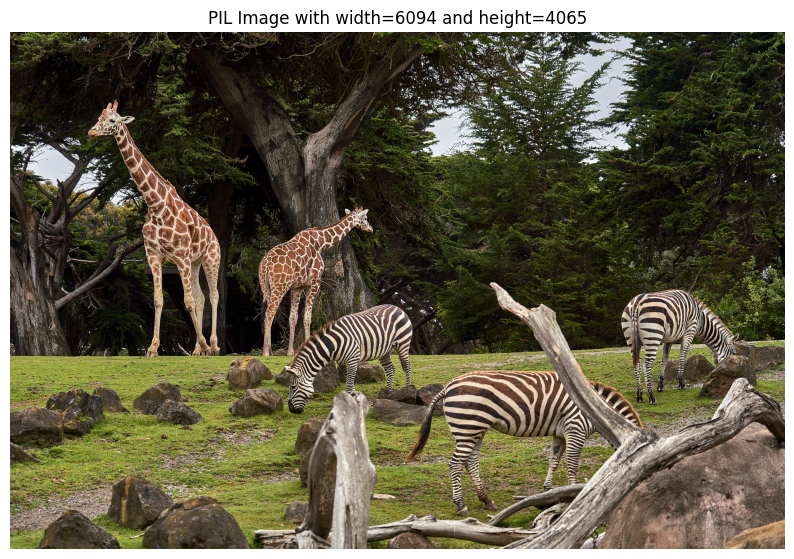

In [9]:
img = Image.open(Config.image_path)
show(img, title=f'PIL Image with width={img.size[0]} and height={img.size[1]}')

# 4 - Helper functions

Before we start implementing our filtering methods, we need to define some utility functions. We will implement:
* `adaptive_resize` that resizes input image preserving the aspect ratio.
* `convert_boxes` that perform conversion of box coordinates.
* `iou` that measures Intersection Over Union between two tensors of boxes.

## Note about coordinates

In this lab we will follow standard numpy convention. Using upper-left corner of the image as the origin $(0, 0)$, increasing x coordinates to the right, and y coordinates to the bottom. So, if we compare **upper left corner** of the box that has coordinates $(x_1, y_1)$ and **bottom right corner** with coordinates $(x_2, y_2)$, $x_1$ would be smaller than $x_2$, and $y_1$ would be smaller than $y_2$ Also, in `numpy` and `torch` image size is in (height, width) format, while in `PIL` image has size of (width, height).

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/coordinates.png">

## Adaptive resize funtion

The input image to the model should be a square with the size defined in `Config`. However, we also don't want to lose the original ratio of the image and make an elephant out of zebra by using a standard resize. For this purpose, we will implement an **adaptive resize function** that resizes the image, preserving the original ratio of the image dimensions, and then pads by pixels with values $(128, 128, 128)$ to get the desired size.

**Excercise:** implement `adaptive_recise` function:
* calculate resize parameters `new_h` and `new_w` before padding
    * both `new_h` and `new_w` has to be <= `size`
    * when calculating the number of pixels, don't round down!
        * Use `round()` instead of `int()`
* determine the number of pixels to pad from left, top, right, and bottom
    * if the image is wide, padding should be equally distributed between top and bottom
    * if the image is tall, padding should be equally distributed between right and left
    * if the padding amount is not divisible by 2, you should give an extra pixel to the left or top, depending on the image ratio
* use `transforms.Resize((height, width))` to resize the image
* use `transforms.Pad` to padd the image (padding value is `(128, 128, 128)`


In [12]:
# VALIDATION_FIELD[func] adaptive_resize

def adaptive_resize(img, size=Config.img_size, fill=(128, 128, 128)):
    """
    Converts PIL image from (w, h) to (size, size),
    preserving aspect ratio and padding the needed dimensions
    by pixels with values (128, 128, 128)

    Arguments:
    img - PIL.Image.Image, input image
    size - int, desired size of the output image
    fill - tuple, value of pixels to fill with

    Returns:
    padded - PIL.Image.Image, output resized image
    resize_params - dict, containing:
                    (h, w): original size,
                    (new_h, new_w): resized size before padding,
                    padding: tuple of number of pixels to padd from left, top, right and bottom (in that order)
    """
    w, h = img.size
    ### START CODE HERE ### (≈12 lines of code)
    # calculate the dimensions of a resized image (before padding)
    new_h = round(h * (size / max(w, h)))
    new_w = round(w * (size / max(w, h)))

    # determine the bigger side
    max_wh = max(new_h, new_w)

    # calculate the amount of padding
    h_padding = max_wh - new_h
    w_padding = max_wh - new_w

    # add one pixel to left and top in case if totall padding is odd
    l_pad = w_padding // 2
    t_pad = h_padding // 2
    r_pad = w_padding - l_pad
    b_pad = h_padding - t_pad
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))

    # use torch.transforms to transform the image
    resized = transforms.Resize((new_h, new_w))(img)
    padded = transforms.Pad(padding, fill=fill)(resized)
    ### END CODE HERE ###
    resize_param = {
        'original': (h, w),
        'resized': (new_h, new_w),
        'padding': padding
    }
    return padded, resize_param

original size: (4065, 6094)
resized size: (277, 416)
padding: (0, 69, 0, 70)


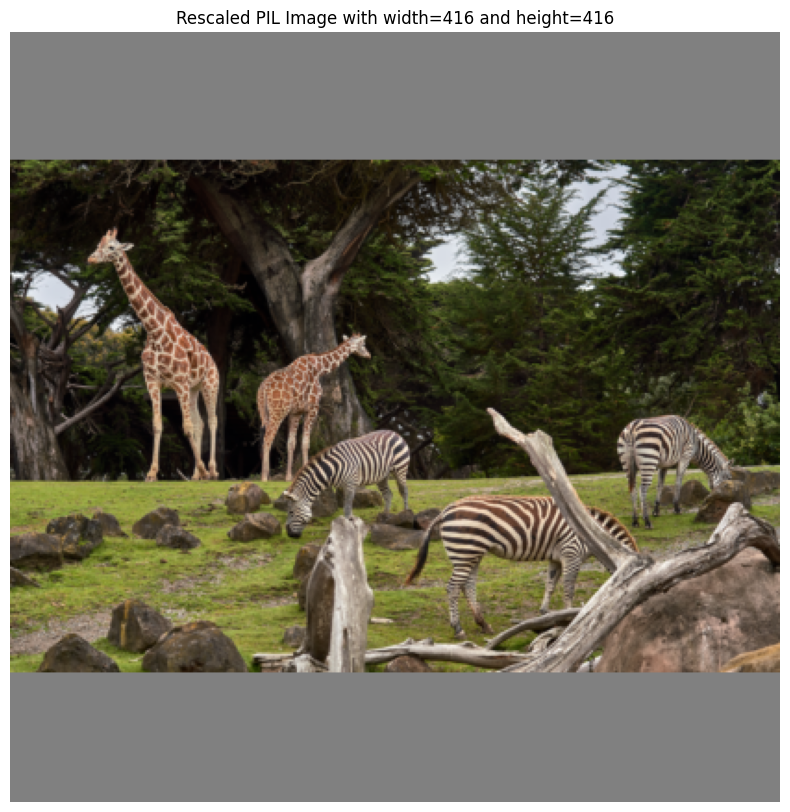

In [13]:
resized_img, resize_params = adaptive_resize(img)
print('original size:', resize_params['original'])
print('resized size:', resize_params['resized'])
print('padding:', resize_params['padding'])
show(resized_img, title=f'Rescaled PIL Image with width={resized_img.size[0]} and height={resized_img.size[1]}')

**Expected output:**

<table>
    <tr>
        <td><b>original:</b></td>
      <td>(4065, 6094)</td>
    </tr>
    <tr>
        <td><b>resized:</b></td>
      <td>(277, 416)</td>
    </tr>
    <tr>
        <td><b>padding:</b></td>
      <td>(0, 70, 0, 69)</td>
    </tr>
</table>

original size: (6094, 4065)
resized size: (416, 277)
padding: (69, 0, 70, 0)


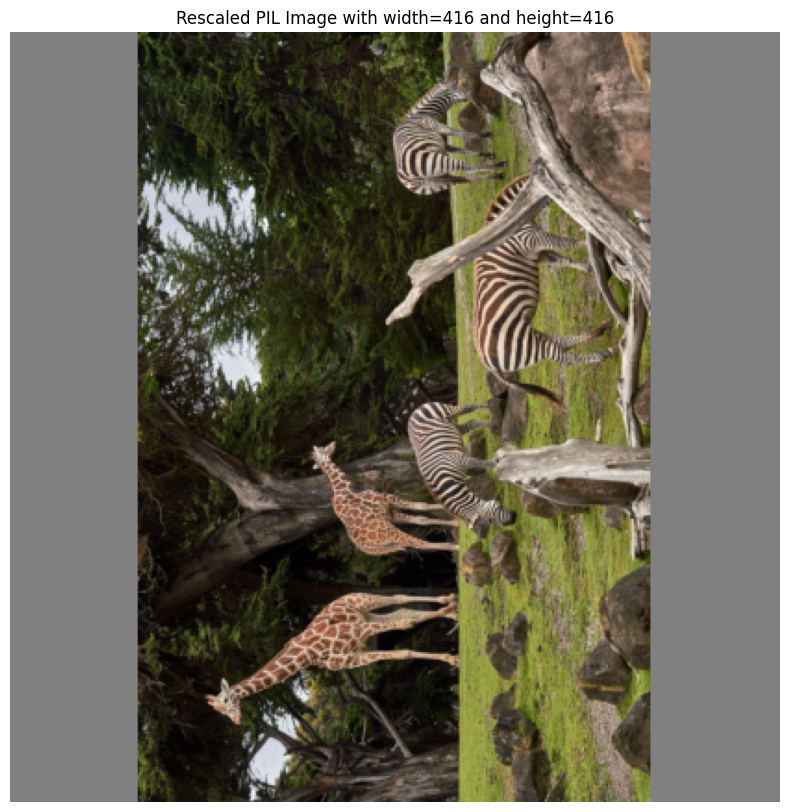

In [14]:
resized_img, resize_params = adaptive_resize(img.transpose(Image.ROTATE_90))
print('original size:', resize_params['original'])
print('resized size:', resize_params['resized'])
print('padding:', resize_params['padding'])
show(resized_img, title=f'Rescaled PIL Image with width={resized_img.size[0]} and height={resized_img.size[1]}')

**Expected output:**

<table>
    <tr>
        <td><b>original:</b></td>
      <td>(6094, 4065)</td>
    </tr>
    <tr>
        <td><b>resized:</b></td>
      <td>(416, 277)</td>
    </tr>
    <tr>
        <td><b>padding:</b></td>
      <td>(70, 0, 69, 0)</td>
    </tr>
</table>

### Convert Boxes

**Excercise:** implement `convert_boxes` that converts a tensor of boxes from format (x center, y center, width, height) to (x1, y1, x2, y2).

In [ ]:
# VALIDATION_FIELD[func] convert_boxes

def convert_boxes(boxes):
    """
    Converts boxes from (x center, y center, width, height) to
    (x1, y1, x2, y2) where x1, y1 is an upper left corner
    and x2, y2 is a lower right corner

    Arguments:
    boxes - torch.Tensor, input boxes of shape [batch_size, 4]

    Returns:
    new_boxes - torch.Tensor, boxes in x1y1x2y2 format of shape [batch_size, 4]
    """
    new_boxes = boxes.clone()
    ### START CODE HERE ### (≈4 lines of code)
    new_boxes[:,0] =
    new_boxes[:,1] =
    new_boxes[:,2] =
    new_boxes[:,3] =
    ### END CODE HERE ###
    return new_boxes

In [ ]:
boxes = torch.tensor([[5, 5, 2, 2],[1, 2, 1, 1]]).float()
print('converted:', convert_boxes(boxes))

**Expected Output:**
<table>
    <tr>
        <td><b>converted</b></td>
        <td>tensor([[4.0000, 4.0000, 6.0000, 6.0000],<br>
        [0.5000, 1.5000, 1.5000, 2.5000]])</td>
    </tr>
</table>


### Intersection over Union (iou)

Finally, the last function we need to implement is `iou` or **Intersection over Union**. The diagram below shows how to calculate this value:

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/IoU.png">

**Excercise:** implement intersection over union between a comparison box `box1` and a batch of boxes `box2`.
* Make sure that your function supports parallelization (performs computations without for-loops)!
    * `box1` is a comparison box of shape [1, 4]
    * `box2` is a **batch** of boxes to compare with `box1`
* Also, be careful with the 0-division. If the union area of two boxes is 0, you should assign `iou = 0`

In [ ]:
# VALIDATION_FIELD[func] iou

def iou(box1, box2):
    """
    Returns the IoU of two bounding boxes

    The function has to support a batched input.
    So, it should work when box1 has a shape of [1, 4]
    and box2 has a shape [15, 4], for example.

    Arguments:
    box1 - torch.Tensor of shape [1, 4] of boxes in x1y1x2y2 format
    box2 - torch.Tensor of shape [batch_size, 4] of boxes x1y1x2y2 format

    Returns:
    iou - torch.Tensor of shape [batch_size] that contains iou predictions
    """
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    ### START CODE HERE ###
    # get the coordinates of the intersection rectangle (≈ 4 lines of code)
    inter_rect_x1 =
    inter_rect_y1 =
    inter_rect_x2 =
    inter_rect_y2 =

     # Intersection area (≈ 3 lines of code)
    inter_width =
    inter_height =
    inter_area =

    # Union Area (≈ 3 lines of code)
    b1_area =
    b2_area =
    union_area =
    iou =
    ### END CODE HERE ###

    # replace nan with 0
    iou[torch.isinf(iou)] = 0
    return iou

In [ ]:
box1 = torch.tensor([[1, 2, 3, 4]]).float()
box2 = torch.tensor([[1, 2, 3, 4],
                     [2, 1, 4, 3],
                     [5, 6, 7, 8],
                     [1, 4, 2, 5]]).float()

print('IoU:', iou(box1, box2))

**Expected Output:**
<table>
    <tr>
        <td><b>IoU</b></td>
        <td>tensor([1.0000, 0.1429, 0.0000, 0.0000])</td>
    </tr>
</table>

# 5 - Filtering
### Probability score filtering

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/probability_score_filtering.png">

The first filtering tecnhique we will be using is called **score** filtering. To use this filtering method we first need to compute the joint probabilty that the detected object is of the given class:
$$P(\text{object} \cap \text{class[i]}) = P(\text{object}) \cdot P(\text{class[i]}) = p_c * p_i$$

Then using these probabilities, we can:
1. find the most likely class candidate for a given box
2. filter out unlikely boxes whose joint probability score is less than a threshold value

**Excercise:** Implement confidence thresholding

In [ ]:
# VALIDATION_FIELD[func] filter_by_confidence

def filter_by_confidence(boxes, p_c_prob, class_prob, conf_thresh=Config.conf_thresh):
    """
    Filters boxes by confidence

    Arguments:
    boxes - torch.tensor of shape [batch, 4] boxes in the format [x_center, y_center, width, height]
    p_c_prob - torch.tensor of shape [batch, 1] probabilities of an object
    class_prob - torch.tensor of shape [batch, 80]

    Returns:
    boxes - torch.tensor of shape [filtered, 4] filtered boxes
    box_scores - torch.tensor of shape [filtered, 1] joint proboability scores of boxes
    box_classes - torch.tensor of shape [filtered, 1] the most likely class index for a box
    """
    ### START CODE HERE ### (≈3 lines of code)
    # calculate joint probability p_c * p_i
    scores =
    # find the class with maximum probability for each box using scores
    box_scores, box_classes =
    # create a filter for removing unlikely boxes using threshold
    mask =
    ### END CODE HERE ###

    # apply mask
    boxes = boxes[mask]
    box_scores = box_scores[mask]
    box_classes = box_classes[mask]
    return boxes, box_scores, box_classes

In [ ]:
boxes = torch.tensor([[ 8.,  9., 16., 18.],
                      [ 4.,  6.,  8., 12.],
                      [ 6.,  7., 12., 14.],
                      [ 2.,  9.,  4., 18.],
                      [ 8.,  3., 16.,  6.]])
p_c_prob = torch.tensor([[0.4058],[0.8206],[0.2455],[0.2990],[0.0327]])
# for testing we will use `num_classes=8`
class_prob = torch.tensor([[0.1671, 0.8980, 0.5258, 0.9354, 0.9485, 0.3799, 0.0241, 0.2106],
                           [0.8294, 0.4328, 0.6154, 0.0256, 0.5209, 0.1788, 0.7997, 0.4718],
                           [0.8507, 0.1390, 0.2791, 0.3575, 0.6461, 0.3769, 0.6058, 0.1949],
                           [0.5336, 0.9761, 0.8537, 0.6989, 0.2038, 0.5689, 0.5464, 0.1366],
                           [0.0486, 0.0660, 0.3141, 0.8351, 0.5842, 0.9983, 0.4926, 0.5212]])
boxes, box_scores, box_classes = filter_by_confidence(boxes, p_c_prob, class_prob, conf_thresh=0.35)
print('boxes:', boxes)
print('scores:', box_scores)
print('class index:', box_classes)

**Expected Output:**
<table>
    <tr>
        <td><b>boxes</b></td>
        <td>tensor([[ 8.,  9., 16., 18.], <br>
        [ 4.,  6.,  8., 12.]]</td>
    </tr>
    <tr>
        <td><b>scores</b></td>
        <td>tensor([0.3849, 0.6806])</td>
    </tr>
    <tr>
        <td><b>class index</b></td>
        <td>tensor([4, 0])</td>
    </tr>               
</table>

## Non-Max Suppression filtering

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/nms_filtering.png">

After applying confidence thresholding, we are left with ~ 20 boxes when the actual number of objects is 3! The problem here is that all of them pretty accurately describe the location of the object. The solution is simple: find the most likely candidates, and remove the ones that have a high overlap. This is basically the whole idea behind **Non-Max Suppression** algorithm.

More concretely, to implement the Non-Max Suppression Algorithm, we need to do the following:
1. Iterate over each unique class `c` in the predictions:
2. Select a subset of boxes and scores that correspond to class `c`
3. Sort this subset of boxes (in descending order) by detection scores
4. Iterate until we have items in the subset:
    1. Save first most likely box
    2. Compute `iou` between the first most likely box and the rest
    3. Filter out remaining boxes by `nms_threshold`
    4. Remove first most likely box from the subset
5. Return selected boxes, their scores, and class indices

**Excercise:** implement Non-Max Supression algorithm

In [ ]:
# VALIDATION_FIELD[func] non_max_supression

def non_max_supression(boxes, box_scores, box_classes, nms_thres=Config.nms_thresh):
    """
    Performs Non-Max Suppression Algorithm

    Arguments:
    boxes - torch.tensor of shape [batch, 4] boxes in the x1y1x2y2 format
    box_scores - torch.tensor of shape [batch, 1] joint proboability scores of boxes
    box_classes - torch.tensor of shape [batch, 1] the most likely class index for each box

    Return:
    boxes - torch.tensor of shape [filtered, 4] filtered boxes in the x1y1x2y2 format
    box_scores - torch.tensor of shape [filtered, 1] joint proboability scores of boxes
    box_classes - torch.tensor of shape [filtered, 1] the most likely class index for each box
    """
    predictions = []

    ### START CODE HERE ###
    unique_labels =
    for c in unique_labels:
        # choose only member of class c
        detection_boxes =
        detection_scores =
        # sort boxes by scores
        sort_index =
        detection_boxes =
        detection_scores =
        while detection_boxes.shape[0] > 1:
            # save first most-probable box
            predictions.append([detection_boxes[0], detection_scores[0], c])
            # perform iou
            iou_values =
            # filter out remaining boxes using threshold
            iou_filter =
            detection_boxes  = detection_boxes[1:][iou_filter]
            detection_scores = detection_scores[1:][iou_filter]
        if detection_boxes.shape[0] > 0:
            predictions.append([detection_boxes[0], detection_scores[0], c])
    ### END CODE HERE ###

    boxes = torch.stack([x[0] for x in predictions])
    box_scores = torch.tensor([x[1] for x in predictions])
    box_classes = torch.tensor([x[2] for x in predictions])
    return boxes, box_scores, box_classes

In [ ]:
boxes = torch.tensor([[213.1915, 242.9775, 349.4505, 355.3651],
                      [216.4065, 241.9519, 363.9741, 354.2513],
                      [ 20.6423,   6.6963, 160.5648, 307.5111],
                      [ 23.9501,  12.4610, 174.3551, 303.5546],
                      [ 20.3151,  19.1298, 161.0345, 307.2794],
                      [ 26.9205,  25.4599, 172.5603, 302.3964],
                      [182.9737, 129.4792, 312.9923, 303.7195],
                      [191.5784, 127.7021, 324.2952, 307.8519],
                      [181.7884, 135.8694, 314.2904, 318.8308],
                      [204.8123, 234.1404, 355.8813, 365.6572]])
box_scores = torch.tensor([0.9979, 0.9601, 0.9871, 0.9520, 0.9966, 0.9800, 0.9936, 0.8047, 0.9679, 0.9608])
box_classes = torch.tensor([22, 22, 23, 23, 23, 23, 23, 23, 23, 22])
boxes, box_scores, box_classes = non_max_supression(boxes, box_scores, box_classes)
print('filtered boxes:', boxes)
print('corresponding scores:', box_scores)
print('class index:', box_classes)

**Expected Output:**
<table>
    <tr>
        <td><b>boxes</b></td>
        <td>tensor([[213.1915, 242.9775, 349.4505, 355.3651], <br>
                    [ 20.3151,  19.1298, 161.0345, 307.2794],<br>
                    [182.9737, 129.4792, 312.9923, 303.7195]])</td>
    </tr>
    <tr>
        <td><b>scores</b></td>
        <td>tensor([0.9979, 0.9966, 0.9936])</td>
    </tr>
    <tr>
        <td><b>class index</b></td>
        <td>tensor([22, 23, 23])</td>
    </tr>               
</table>

# 5 - Putting everything together

Let's put everything together into one algorithm

**Excercise** implement predict function:

1. Resize input `PIL` image
2. Transform image to tensor (hint use `transforms`) and pass it to device
3. Get an extra dimension to create a batch
4. Push your image through the model
5. Split detection vector into `boxes`, `p_c_prob`, and `class_prob`
6. Perform confidence thresholding
7. Convert boxes to x1y1x2y2 format
8. Perform Non-Max Thresholding
9. Return boxes, their scores, class id, and resize_parameters

In [ ]:
# VALIDATION_FIELD[func] predict

def predict(img, model, conf_thresh=Config.conf_thresh, nms_thres=Config.nms_thresh, device=Config.device):
    """
    Performs YOLO_v3 prediction on the image

    Arguments:
    img - PIL.Image.Image, input PIL image
    model - nn.Module, torch model for prediction (backbone of YOLO)

    Return:
    boxes - torch.tensor of shape [filtered, 4] filtered boxes
    box_scores - torch.tensor of shape [filtered, 1] joint proboability scores of boxes
    box_classes - torch.tensor of shape [filtered, 1] the most likely class index for each box
    """
    ### START CODE HERE ### (≈11 lines of code)
    # resize image to the target size
    img, resize_params =
    # convert image to Tensor and pass it to device
    image_tensor =
    # create a batch of single image [batch_size, chanels, height, width]
    image_batch =
    # run inference on the model and get detections
    with torch.no_grad():
        detections =
        # split detections
        boxes =
        p_c_prob =
        class_prob =
        # filter by confidence
        boxes, box_scores, box_classes =
        # preprocess boxes to x1y1x2y2 format
        boxes =
        # filter by non-max-supression
        boxes, box_scores, box_classes =
    ### END CODE HERE ###
    return boxes, box_scores, box_classes, resize_params

In [ ]:
boxes, box_scores, box_classes, resize_params = predict(img, model)
print('boxes:', boxes)
print('scores:', box_scores)
print('class index:', box_classes)

**Expected Output:**
<table>
    <tr>
        <td><b>boxes</b></td>
        <td>tensor([[328.0109, 206.3550, 393.1273, 268.4946], <br>
        [146.6449, 214.6219, 217.2606, 272.8861],<br>
        [218.7541, 242.6662, 324.1006, 326.5118],<br>
        [ 38.9592, 100.0730, 118.3660, 248.0865],<br>
        [130.5345, 163.0148, 197.8460, 244.1906]])</td>
    </tr>
    <tr>
        <td><b>scores</b></td>
        <td>tensor([0.9992, 0.9987, 0.3262, 0.9966, 0.9689])</td>
    </tr>
    <tr>
        <td><b>class index</b></td>
        <td>tensor([22, 22, 22, 23, 23])</td>
    </tr>               
</table>

# 6 - Visualizing the results

Next, after we extracted the needed boxes, we will need to see how they would look on the original image. To do so, we can use `parameters` that we saved in `resize_params` to resize the box to the original image scale.

**Note:** Here we start with a box in $(x_1, y_1, x_2, y_2)$ format and convert it to $(x_1, y_1, \text{width}, \text{height})$ (standard `matplotlib` format)

In [ ]:
def resize_box(box, resize_params):
    """
    Resizes box into the sclae of the original image, and converts to x1, y1, width, height format
    """
    # unpacking inputs
    x1, y1, x2, y2 = box
    h_scale = resize_params['original'][0] / resize_params['resized'][0]
    w_scale = resize_params['original'][1] / resize_params['resized'][1]

    # resize height and width
    box_h = (y2 - y1) * h_scale
    box_w = (x2 - x1) * w_scale
    y1 = (y1 - resize_params['padding'][1]) * h_scale
    x1 = (x1 - resize_params['padding'][0]) * w_scale
    return x1, y1, box_w, box_h

In [ ]:
def visualize(boxes, scores, classes, resize_params, cmap='tab20b'):
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)
    if boxes is not None:
        # generate random colors
        unique_labels = classes.unique()
        cmap = plt.get_cmap(cmap)
        colors = [cmap(i) for i in np.linspace(0, 1, len(boxes))]
        bbox_colors = random.sample(colors, len(unique_labels))

        # browse detections and draw bounding boxes
        for box, conf, cls_pred in zip(boxes, scores, classes):
            x1, y1, box_w, box_h = resize_box(box, resize_params)
            color = bbox_colors[torch.nonzero(unique_labels == cls_pred, as_tuple=False).item()]
            bbox = patches.Rectangle((x1, y1), box_w, box_h,
                linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)
            plt.text(x1, y1,
                    s=class_labels[int(cls_pred)] + f' {conf:.3f}',
                    color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})
    plt.axis('off')
    plt.show()

In [ ]:
boxes, scores, classes, resize_params = predict(img, model)
visualize(boxes, scores, classes, resize_params)

Yay! As you can see, the model successfully identified all objects on the image. The zebra in the foreground has a confidence score of `0.326`, which is not surprising because it's partially covered by a trunk, which makes it harder for a Conv net to find the regular features of a zebra.

# 7 - Try your own

In [ ]:
your_path = ''
img = Image.open(your_path)
boxes, scores, classes, resize_params = predict(img, model)
visualize(boxes, scores, classes, resize_params)